In [1]:
import os
import sys
import time

import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from matplotlib import pyplot as plt
from scipy.ndimage.interpolation import rotate
from torchvision import datasets, transforms
from scipy.optimize import curve_fit, least_squares, minimize

In [2]:
#arguments
batch_size = 64
test_batch_size = 64

epochs = 100
learning_rate = 0.001
momentum = 0.9 # 'SGD momentum'
latent_space=16

In [3]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [4]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=img_transform),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
                   transform=img_transform),
    batch_size=test_batch_size, shuffle=True, **kwargs)

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self, height, width, device):
        super(AutoEncoder, self).__init__()

        self.height = height
        self.width = width
        self.device = device

        self.feat_sz = 16 * 22 * 22
        
        # Init model layers
        self.down1 = nn.Conv2d( 1,  8, 3) #shape -2
        self.down2 = nn.Conv2d( 8, 16, 3) #shape -2
        self.down3 = nn.Conv2d(16, 16, 3) #shape -2
        
        self.latentd = nn.Linear(self.feat_sz, 16)
        #decoder
        self.latentu = nn.Linear(16, self.feat_sz)
        
        self.up3   = nn.ConvTranspose2d(16, 16, 3)
        self.up2   = nn.ConvTranspose2d(16, 8, 3)
        self.up1   = nn.ConvTranspose2d(8, 1, 3)
        
    def encode(self, x, params):
        x = F.relu(self.down1(x))
        x = F.relu(self.down2(x))
        x = F.relu(self.down3(x))
        x =  x.view(-1, 16 * 22 * 22) #flatten
        x = self.latentd(x)
        x = self.feature_transformer(x, params)
        return x
    
    def decode(self, x):
        x = self.latentu(x)
        x = x.view(-1, 16, 22, 22)
        x = F.relu(self.up3(x))
        x = F.relu(self.up2(x))
        x = torch.sigmoid(self.up1(x))
        return x

    def forward(self, x, params):
        return self.decode(self.encode(x, params))
    
    def feature_transformer(self, input, params):
        """For now we assume the params are just a single rotation angle

        Args:
            input: [N,c] tensor, where c = 2*int
            params: [N,1] tensor, with values in [0,2*pi)
        Returns:
            [N,c] tensor
        """
        # First reshape activations into [N,c/2,2,1] matrices
        x = input.view(input.size(0),input.size(1)//2,2,1)
        # Construct the transformation matrix
        sin = torch.sin(params)
        cos = torch.cos(params)
        transform = torch.cat([sin, -cos, cos, sin], 1)
        transform = transform.view(transform.size(0),1,2,2).to(self.device)
        # Multiply: broadcasting taken care of automatically
        # [N,1,2,2] @ [N,channels/2,2,1]
        output = torch.matmul(transform, x)
        # Reshape and return
        return output.view(input.size())

In [6]:
model = AutoEncoder(28, 28, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# l = next(iter(test_loader))
# n_rot = 64

# angles = torch.linspace(0, 2*np.pi, steps=n_rot)
# angles = angles.view(n_rot, 1)

# data = l[0]
# data = data.view(data.size(0), -1)
# data = data.repeat(n_rot, 1)
# data = data.to(device)

# model.forward(l[0].to(device), angles).shape

In [8]:
def rotate_tensor(input):
    """Nasty hack to rotate images in a minibatch, this should be parallelized
    and set in PyTorch

    Args:
        input: [N,c,h,w] **numpy** tensor
    Returns:
        rotated output and angles in radians
    """
    angles = 2*np.pi*np.random.rand(input.shape[0])
    angles = angles.astype(np.float32)
    outputs = []
    for i in range(input.shape[0]):
        output = rotate(input[i,...], 180*angles[i]/np.pi, axes=(1,2), reshape=False)
        outputs.append(output)
    return np.stack(outputs, 0), angles

In [9]:
def train(model, device, train_loader, optimizer, epoch, log_interval=10):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Reshape data
        targets, angles = rotate_tensor(data.numpy())
        targets = torch.from_numpy(targets).to(device)
        angles = torch.from_numpy(angles).to(device)
        angles = angles.view(angles.size(0), 1)

        # Forward pass
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data, angles)

        # Binary cross entropy loss
        loss_fnc = nn.BCELoss(reduction='sum')
        loss = loss_fnc(output, targets)

        # Backprop
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            sys.stdout.write('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\r'
                .format(epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            sys.stdout.flush()

In [10]:
%%time
for epoch in range(1, epochs + 1):
    start = time.time()
    train(model, device, train_loader, optimizer, epoch)
    end = time.time()
    sys.stdout.write('\n Time: {0:.2f}s\n'.format(end - start))

Train Epoch: 1 [59520/60000 (99%)]	Loss: 7612.9038095
 Time: 15.92s
Train Epoch: 2 [59520/60000 (99%)]	Loss: 6489.326172
 Time: 14.49s
Train Epoch: 3 [59520/60000 (99%)]	Loss: 6222.504883
 Time: 15.00s
Train Epoch: 4 [59520/60000 (99%)]	Loss: 6062.408203
 Time: 14.75s
Train Epoch: 5 [59520/60000 (99%)]	Loss: 6114.435547
 Time: 14.79s
Train Epoch: 6 [59520/60000 (99%)]	Loss: 5807.885742
 Time: 14.91s
Train Epoch: 7 [59520/60000 (99%)]	Loss: 5614.795410
 Time: 15.24s
Train Epoch: 8 [59520/60000 (99%)]	Loss: 5384.790039
 Time: 15.01s
Train Epoch: 9 [59520/60000 (99%)]	Loss: 5599.965820
 Time: 14.78s
Train Epoch: 10 [59520/60000 (99%)]	Loss: 5137.341797
 Time: 14.84s
Train Epoch: 11 [59520/60000 (99%)]	Loss: 5679.998535
 Time: 15.18s
Train Epoch: 12 [59520/60000 (99%)]	Loss: 5905.425293
 Time: 14.68s
Train Epoch: 13 [59520/60000 (99%)]	Loss: 4980.961914
 Time: 14.82s
Train Epoch: 14 [59520/60000 (99%)]	Loss: 5438.557129
 Time: 14.97s
Train Epoch: 15 [59520/60000 (99%)]	Loss: 5275.809570
 T

In [11]:
torch.save(model.state_dict(), 'mnist_Conv2D_model')

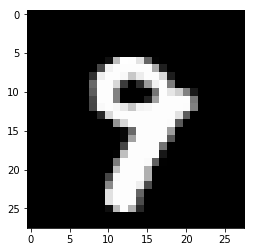

In [25]:
l = next(iter(test_loader))
l00 = l[0][:1,:,:]
plt.imshow(l00.numpy()[0, 0,:,:], cmap='gray')
plt.show()

In [26]:
n_rot = 32
with torch.no_grad():
    angles = torch.linspace(0, 2*np.pi, steps=n_rot)
    angles = angles.view(n_rot, 1)

    data = l00[0]
    data = data.view(data.size(0), -1)
    data = data.repeat(n_rot, 1)
    data = data.view(-1, 1, 28, 28).to(device)

    output = model.encode(data, angles)
    output = output.cpu()

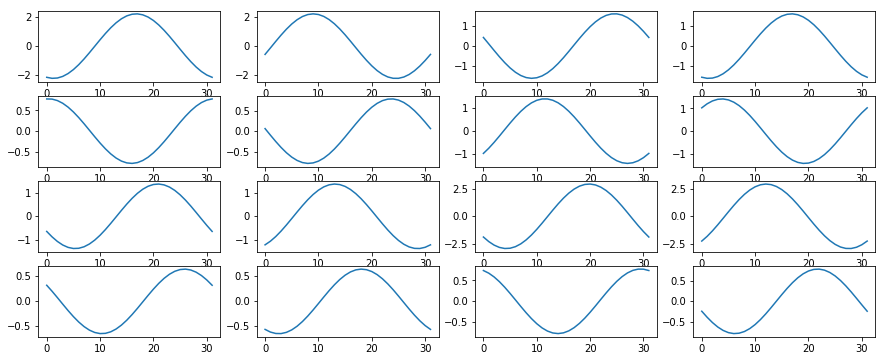

In [27]:
o_np = output.numpy()
f, ax = plt.subplots(4, 4, figsize=(15, 6))
for i in range(4): 
    for j in range(4):
        ax[i][j].plot(o_np[:,i*4 + j])